In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import itertools
import math
import pandas as pd
import os
import numpy as np

In [2]:
# GLOBALS
LOCAL_DATA_ROOT = '/Users/varunn/Documents/kaggle/'
INP_PATH = LOCAL_DATA_ROOT + 'entity-annotated-corpus/'
INP_FN = INP_PATH + 'ner_dataset.csv'

In [3]:
ner_df = pd.read_csv(INP_FN)

In [4]:
print ner_df.shape
print ner_df.head()

(1048575, 4)
    Sentence #           Word  POS Tag
0  Sentence: 1      Thousands  NNS   O
1          NaN             of   IN   O
2          NaN  demonstrators  NNS   O
3          NaN           have  VBP   O
4          NaN        marched  VBN   O


In [5]:
print ner_df['Tag'].value_counts()

O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
dtype: int64


In [6]:
print ner_df['Sentence #'].nunique()
sent = ner_df.loc[0, 'Sentence #']
print type(sent)
print isinstance(sent, basestring)
print 'Sentence:' in sent

47959
<type 'str'>
True
True


In [7]:
sentences_words = []
sentences_tags = []
curr_sent_num = -1
current_sentence_words = []
current_sentence_tags = []
for sent_num, word, tag in ner_df[['Sentence #', 'Word', 'Tag']].values:
    if isinstance(sent_num, basestring) and 'Sentence: ' in sent_num:
        curr_sent_num = int(sent_num.split(':')[1].strip())
        
        if current_sentence_words and current_sentence_tags:
            sentences_words.append(current_sentence_words)
            sentences_tags.append(current_sentence_tags)
            
        current_sentence_words = []
        current_sentence_tags = []
        
    current_sentence_words.append(word.decode(errors='replace'))
    current_sentence_tags.append(tag)

In [8]:
print len(sentences_tags)
print len(sentences_words)

47958
47958


In [9]:
sentences_words[0]

[u'Thousands',
 u'of',
 u'demonstrators',
 u'have',
 u'marched',
 u'through',
 u'London',
 u'to',
 u'protest',
 u'the',
 u'war',
 u'in',
 u'Iraq',
 u'and',
 u'demand',
 u'the',
 u'withdrawal',
 u'of',
 u'British',
 u'troops',
 u'from',
 u'that',
 u'country',
 u'.']

In [10]:
train_size = int(len(sentences_words) * 0.8)

train_sentences_words = sentences_words[:train_size]
train_sentences_tags = sentences_tags[:train_size]
test_sentences_words = sentences_words[train_size:]
test_sentences_tags = sentences_tags[train_size:]

print 'Train:', len(train_sentences_words), len(train_sentences_tags)
print 'Test:', len(test_sentences_words), len(test_sentences_tags)

Train: 38366 38366
Test: 9592 9592


In [11]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import scipy

In [16]:
count_vectorizer = CountVectorizer().fit(map(
     lambda s: ' '.join(s), train_sentences_words))

In [17]:
count_vectorizer

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [18]:
bows = count_vectorizer.transform(map(lambda s: ' '.join(s), train_sentences_words))

In [19]:
bows.shape

(38366, 25446)

In [20]:
tmp_words = train_sentences_words[0]
tmp_tags = train_sentences_tags[0]
tmp_bows = bows[0]
X = []
y = []
for w, t in zip(tmp_words, tmp_tags):
    print w
    v = count_vectorizer.transform([w])[0]
    print v.shape
    v = scipy.sparse.hstack([v, tmp_bows])
    X.append(v)
    y.append(t)

Thousands
(1, 25446)
of
(1, 25446)
demonstrators
(1, 25446)
have
(1, 25446)
marched
(1, 25446)
through
(1, 25446)
London
(1, 25446)
to
(1, 25446)
protest
(1, 25446)
the
(1, 25446)
war
(1, 25446)
in
(1, 25446)
Iraq
(1, 25446)
and
(1, 25446)
demand
(1, 25446)
the
(1, 25446)
withdrawal
(1, 25446)
of
(1, 25446)
British
(1, 25446)
troops
(1, 25446)
from
(1, 25446)
that
(1, 25446)
country
(1, 25446)
.
(1, 25446)


In [22]:
print scipy.sparse.vstack(X).shape
print y

(24, 50892)
['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


In [23]:
def sentence_to_instances(words, tags, bow, count_vectorizer):
    X = []
    y = []
    for w, t in zip(words, tags):
        v = count_vectorizer.transform([w])[0]
        v = scipy.sparse.hstack([v, bow])
        X.append(v)
        y.append(t)
        
    return scipy.sparse.vstack(X), y

def sentences_to_instances(sentences_words, sentences_tags,
                           count_vectorizer):
    bows = count_vectorizer.transform(map(lambda s: ' '.join(s),
                                          sentences_words))
    X = []
    y = []
    for words, tags, bow in zip(sentences_words, sentences_tags, bows):
        sent_X, sent_y = sentence_to_instances(words, tags, bow,
                                               count_vectorizer)
        X.append(sent_X)
        y += sent_y
        
    return scipy.sparse.vstack(X), np.array(y)

In [24]:
train_X, train_y = sentences_to_instances(train_sentences_words,
                                          train_sentences_tags,
                                          count_vectorizer)

In [25]:
train_X.shape

(839214, 50892)

In [26]:
train_y.shape

(839214,)

In [27]:
test_X, test_y = sentences_to_instances(test_sentences_words, test_sentences_tags, count_vectorizer)
test_X.shape, test_y.shape

((209353, 50892), (209353,))

In [28]:
#train_X_arr = train_X.toarray()
#test_X_arr = test_X.toarray()

In [29]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

In [ ]:
clf = GradientBoostingClassifier().fit(train_X.toarray(), train_y)

# Seq2seq

In [12]:
train_sentences_words[0]

[u'Thousands',
 u'of',
 u'demonstrators',
 u'have',
 u'marched',
 u'through',
 u'London',
 u'to',
 u'protest',
 u'the',
 u'war',
 u'in',
 u'Iraq',
 u'and',
 u'demand',
 u'the',
 u'withdrawal',
 u'of',
 u'British',
 u'troops',
 u'from',
 u'that',
 u'country',
 u'.']

In [16]:
vocab = set(itertools.chain(*[[w for w in s] for s in train_sentences_words]))

In [17]:
len(vocab)

31809

In [18]:
tags = set(itertools.chain(*[[t for t in s] for s in train_sentences_tags]))

In [19]:
sentences_len = map(lambda s: len(s), train_sentences_words)

In [20]:
len(sentences_len)

38366

(array([3.5510e+03, 1.5670e+04, 1.4854e+04, 3.8890e+03, 3.3800e+02,
        5.2000e+01, 1.0000e+01, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  1. ,  11.3,  21.6,  31.9,  42.2,  52.5,  62.8,  73.1,  83.4,
         93.7, 104. ]),
 <a list of 10 Patch objects>)

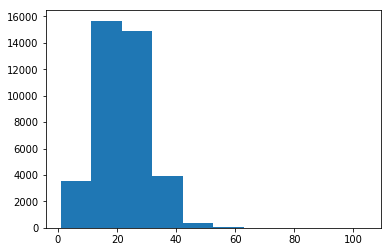

In [21]:
plt.hist(sentences_len)

In [22]:
max(sentences_len)

104

In [23]:
MAX_LEN = 75#max(sentenecs_lens)
VOCAB_SIZE = len(vocab)

In [24]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

/Users/varunn/.virtualenvs/xgb/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [25]:
words_tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters=[],
                            oov_token='__UNKNOWN__')

In [26]:
words_tokenizer.fit_on_texts(map(lambda s: ' '.join(s),
                                 train_sentences_words))

In [28]:
word_index = words_tokenizer.word_index

In [30]:
word_index['__PADDING__'] = 0
index_word = {i: w for w, i in word_index.iteritems()}
print 'Unique Tokens: %d' % (len(word_index))

Unique Tokens: 28824


In [31]:
train_sequences = words_tokenizer.texts_to_sequences(map(
     lambda s: " ".join(s), train_sentences_words))
test_sequences = words_tokenizer.texts_to_sequences(map(
     lambda s: " ".join(s), test_sentences_words))

In [35]:
print len(train_sequences)
print len(train_sequences[0])

38366
24


In [36]:
train_sequences_padded = pad_sequences(sequences=train_sequences,
                                       maxlen=MAX_LEN)
test_sequences_padded = pad_sequences(sequences=test_sequences,
                                      maxlen=MAX_LEN)

In [38]:
print train_sequences[0]
print train_sequences_padded[0]

[257, 5, 935, 16, 1718, 234, 487, 6, 519, 1, 129, 4, 61, 8, 610, 1, 926, 5, 193, 90, 22, 14, 54, 2]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0  257    5  935   16 1718
  234  487    6  519    1  129    4   61    8  610    1  926    5  193
   90   22   14   54    2]


In [39]:
# tags
tags_tokenizer = Tokenizer(num_words=len(tags), filters='', lower=False,
                           oov_token='__UNKNOWN__')

In [40]:
tags_tokenizer.fit_on_texts(map(lambda s: " ".join(s),
                                train_sentences_tags))

In [41]:
tag_index = tags_tokenizer.word_index
tag_index['__PADDING__'] = 0
index_tag = {i: w for w, i in tag_index.iteritems()}

In [44]:
print(len(tag_index))
tag_index

19


{'B-art': 11,
 'B-eve': 12,
 'B-geo': 2,
 'B-gpe': 8,
 'B-nat': 16,
 'B-org': 4,
 'B-per': 6,
 'B-tim': 3,
 'I-art': 13,
 'I-eve': 14,
 'I-geo': 9,
 'I-gpe': 15,
 'I-nat': 17,
 'I-org': 7,
 'I-per': 5,
 'I-tim': 10,
 'O': 1,
 '__PADDING__': 0,
 '__UNKNOWN__': 18}

In [45]:
index_tag_wo_padding = dict(index_tag)

In [46]:
index_tag_wo_padding

{0: '__PADDING__',
 1: 'O',
 2: 'B-geo',
 3: 'B-tim',
 4: 'B-org',
 5: 'I-per',
 6: 'B-per',
 7: 'I-org',
 8: 'B-gpe',
 9: 'I-geo',
 10: 'I-tim',
 11: 'B-art',
 12: 'B-eve',
 13: 'I-art',
 14: 'I-eve',
 15: 'I-gpe',
 16: 'B-nat',
 17: 'I-nat',
 18: '__UNKNOWN__'}

In [47]:
index_tag_wo_padding[tag_index['__PADDING__']] = '0'

In [48]:
index_tag_wo_padding

{0: '0',
 1: 'O',
 2: 'B-geo',
 3: 'B-tim',
 4: 'B-org',
 5: 'I-per',
 6: 'B-per',
 7: 'I-org',
 8: 'B-gpe',
 9: 'I-geo',
 10: 'I-tim',
 11: 'B-art',
 12: 'B-eve',
 13: 'I-art',
 14: 'I-eve',
 15: 'I-gpe',
 16: 'B-nat',
 17: 'I-nat',
 18: '__UNKNOWN__'}

In [49]:
train_tags = tags_tokenizer.texts_to_sequences(map(lambda s: " ".join(s),
                                                   train_sentences_tags))
test_tags = tags_tokenizer.texts_to_sequences(map(lambda s: " ".join(s),
                                                  test_sentences_tags))
train_tags_padded = pad_sequences(sequences=train_tags, maxlen=MAX_LEN)
test_tags_padded = pad_sequences(sequences=test_tags, maxlen=MAX_LEN)

In [50]:
train_tags_padded[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 8, 1, 1, 1, 1, 1], dtype=int32)

In [51]:
train_tags_padded = np.expand_dims(train_tags_padded, -1)
test_tags_padded = np.expand_dims(test_tags_padded, -1)
print train_tags_padded.shape, test_tags_padded.shape

(38366, 75, 1) (9592, 75, 1)


In [53]:
train_tags_padded[0].shape

(75, 1)

In [54]:
for w, t in zip(train_sequences_padded[123], train_tags_padded[123]):
    print index_word[w], index_tag[t[0]]

__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PA

In [55]:
from keras.layers import Dense, LSTM, Dropout, Bidirectional, Input, Embedding
from keras.models import Model

In [56]:
random_embedding_layer = Embedding(input_dim=VOCAB_SIZE, output_dim=300,
                                   input_length=MAX_LEN)
sequence_input = Input(shape=[MAX_LEN,], dtype='int32')
embedded_sequences = random_embedding_layer(sequence_input)
x = Bidirectional(LSTM(units=64, return_sequences=True))(embedded_sequences)
x = Dropout(rate=0.3)(x)
x = Dense(units=32, activation='relu')(x)
preds = Dense(units=len(tag_index), activation='softmax')(x)

model = Model(inputs=sequence_input, outputs=preds)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['sparse_categorical_accuracy'])

In [57]:
print model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 75, 300)           9542700   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 75, 128)           186880    
_________________________________________________________________
dropout_1 (Dropout)          (None, 75, 128)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 75, 32)            4128      
_________________________________________________________________
dense_2 (Dense)              (None, 75, 19)            627       
Total params: 9,734,335
Trainable params: 9,734,335
Non-trainable params: 0
_________________________________________________________________


In [65]:
32*19 + 19

627

In [66]:
model.fit(x=train_sequences_padded, y=train_tags_padded, batch_size=32,
          epochs=10,
          validation_data=(test_sequences_padded, test_tags_padded))

Train on 38366 samples, validate on 9592 samples
Epoch 1/10
38366/38366 [==============================] - 277s 7ms/step - loss: 0.1247 - sparse_categorical_accuracy: 0.9703 - val_loss: 0.0429 - val_sparse_categorical_accuracy: 0.9873
Epoch 2/10
38366/38366 [==============================] - 262s 7ms/step - loss: 0.0364 - sparse_categorical_accuracy: 0.9893 - val_loss: 0.0383 - val_sparse_categorical_accuracy: 0.9885
Epoch 3/10
38366/38366 [==============================] - 256s 7ms/step - loss: 0.0279 - sparse_categorical_accuracy: 0.9914 - val_loss: 0.0387 - val_sparse_categorical_accuracy: 0.9886
Epoch 4/10
38366/38366 [==============================] - 255s 7ms/step - loss: 0.0228 - sparse_categorical_accuracy: 0.9928 - val_loss: 0.0405 - val_sparse_categorical_accuracy: 0.9887
Epoch 5/10
38366/38366 [==============================] - 275s 7ms/step - loss: 0.0187 - sparse_categorical_accuracy: 0.9940 - val_loss: 0.0437 - val_sparse_categorical_accuracy: 0.9886
Epoch 6/10
38366/3836

In [69]:
from sklearn.metrics import classification_report, f1_score

In [70]:
lstm_predicted = model.predict(x=test_sequences_padded)

In [74]:
print(type(lstm_predicted))
print(lstm_predicted.shape)
tmp_pred = lstm_predicted[0]

<type 'numpy.ndarray'>
(9592, 75, 19)


In [82]:
print tmp_pred
tag_pred = np.argmax(tmp_pred, axis=1)
print tag_pred
tag_pred = map(index_tag_wo_padding.get, tag_pred)
print tag_pred
print tag_pred[-len(tmp_pred):]

[[9.9999940e-01 5.1133986e-07 4.3792315e-18 ... 9.1154917e-08
  1.8091484e-16 3.9395717e-19]
 [9.9999988e-01 9.4265651e-08 7.2841990e-20 ... 9.1868273e-09
  1.2606010e-18 1.5080721e-21]
 [1.0000000e+00 4.0962661e-08 2.8506844e-20 ... 5.3263678e-09
  2.7265429e-19 3.4326806e-22]
 ...
 [6.8709634e-09 9.9998462e-01 1.4413334e-10 ... 5.1311055e-10
  9.4567778e-13 1.4875413e-16]
 [7.7630338e-09 9.9999654e-01 1.3339680e-09 ... 4.0580789e-11
  2.2345340e-13 7.7700536e-17]
 [1.2818803e-07 9.9999583e-01 9.3933771e-08 ... 7.2392822e-08
  3.0441330e-11 2.1512337e-13]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 6 5 1 1 1 3 1 1 3 1 1 1 2 1 1 1 1 1 1 1 1 1
 1]
['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'B-per', 'I-per', 'O'

In [83]:
lstm_predicted_tags = []
for s, s_pred in zip(test_sentences_words, lstm_predicted):
    tags = np.argmax(s_pred, axis=1)
    tags = map(index_tag_wo_padding.get, tags)[-len(s):]
    lstm_predicted_tags.append(tags)

In [89]:
print test_sentences_words[0]
print lstm_predicted_tags[0]
print test_sentences_tags[0]

[u'Mr.', u'Nour', u'was', u'arrested', u'in', u'January', u'and', u'spent', u'six', u'weeks', u'in', u'a', u'Cairo', u'jail', u',', u'before', u'his', u'release', u'on', u'bond', u'last', u'week', u'.']
['B-per', 'I-per', 'O', 'O', 'O', 'B-tim', 'O', 'O', 'B-tim', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['B-per', 'I-per', 'O', 'O', 'O', 'B-tim', 'O', 'O', 'B-tim', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [87]:
print 'LSTM'
print '='*15
print classification_report(test_sentences_tags, lstm_predicted_tags)

LSTM
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
      B-art       0.18      0.08      0.11        74
      B-eve       0.46      0.42      0.44        43
      B-geo       0.90      0.92      0.91      4870
      B-gpe       0.95      0.96      0.96      2604
      B-nat       0.65      0.62      0.63        39
      B-org       0.76      0.73      0.75      3204
      B-per       0.88      0.84      0.86      2672
      B-tim       0.96      0.93      0.94      3460
      I-art       0.13      0.10      0.11        30
      I-eve       0.12      0.12      0.12        26
      I-geo       0.75      0.80      0.77      1173
      I-gpe       0.89      0.71      0.79        34
      I-nat       0.00      0.00      0.00         9
      I-org       0.71      0.71      0.71      1739
      I-per       0.91      0.89      0.90      2111
      I-tim       0.84      0.80      0.82       844
          O       1.00      1.00      1.

/Users/varunn/.virtualenvs/xgb/lib/python2.7/site-packages/sklearn/utils/multiclass.py:198: DeprecationWarning: Direct support for sequence of sequences multilabel representation will be unavailable from version 0.17. Use sklearn.preprocessing.MultiLabelBinarizer to convert to a label indicator representation.
  DeprecationWarning)
/Users/varunn/.virtualenvs/xgb/lib/python2.7/site-packages/sklearn/utils/multiclass.py:198: DeprecationWarning: Direct support for sequence of sequences multilabel representation will be unavailable from version 0.17. Use sklearn.preprocessing.MultiLabelBinarizer to convert to a label indicator representation.
  DeprecationWarning)
/Users/varunn/.virtualenvs/xgb/lib/python2.7/site-packages/sklearn/utils/multiclass.py:198: DeprecationWarning: Direct support for sequence of sequences multilabel representation will be unavailable from version 0.17. Use sklearn.preprocessing.MultiLabelBinarizer to convert to a label indicator representation.
  DeprecationWarning

In [88]:
print 'LSTM:', f1_score(test_sentences_tags, lstm_predicted_tags)

LSTM: 0.8998731015733037


/Users/varunn/.virtualenvs/xgb/lib/python2.7/site-packages/sklearn/utils/multiclass.py:198: DeprecationWarning: Direct support for sequence of sequences multilabel representation will be unavailable from version 0.17. Use sklearn.preprocessing.MultiLabelBinarizer to convert to a label indicator representation.
  DeprecationWarning)
/Users/varunn/.virtualenvs/xgb/lib/python2.7/site-packages/sklearn/utils/multiclass.py:198: DeprecationWarning: Direct support for sequence of sequences multilabel representation will be unavailable from version 0.17. Use sklearn.preprocessing.MultiLabelBinarizer to convert to a label indicator representation.
  DeprecationWarning)
/Users/varunn/.virtualenvs/xgb/lib/python2.7/site-packages/sklearn/utils/multiclass.py:198: DeprecationWarning: Direct support for sequence of sequences multilabel representation will be unavailable from version 0.17. Use sklearn.preprocessing.MultiLabelBinarizer to convert to a label indicator representation.
  DeprecationWarning